In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

from darkmod import laue, scan
from darkmod.beam import GaussianLineBeam, HeavysideBeam
from darkmod.crl import CompundRefractiveLens
from darkmod.crystal import Crystal
from darkmod.deformation import straight_edge_dislocation, unity_field
from darkmod.detector import Detector
from darkmod.resolution import PentaGauss

In [2]:
number_of_lenses = 69
lens_space = 1600  # microns
lens_radius = 50  # microns
refractive_decrement = (2.359 / 2.0) * 1e-6
magnification = 15.1
crl = CompundRefractiveLens(
    number_of_lenses, lens_space, lens_radius, refractive_decrement, magnification
)

energy = 19.1  # keV
lambda_0 = laue.keV_to_angstrom(energy)

# Instantiate a cubic AL crystal (space group 225)
unit_cell = [4.0493, 4.0493, 4.0493, 90.0, 90.0, 90.0]

orientation = Rotation.random().as_matrix()
crystal = Crystal(unit_cell, orientation)

# remount the crystal to align Q with z-axis
symmetry_axis = np.array([0, 0, 1])
crystal.align(symmetry_axis, axis=np.array([0, 0, 1]))
crystal.align(
    np.array([0, 1, 0]), axis=np.array([0, 1, 0]), transformation_hkl=symmetry_axis
)
crystal.align(
    np.array([1, 0, 0]), axis=np.array([1, 0, 0]), transformation_hkl=symmetry_axis
)
crystal.remount()  # this updates U and zeros the goniometer.


In [3]:
hkl = np.array([-1, -1, 3])
crystal.goniometer.omega = np.radians(6.431585)


In [4]:
eta = np.radians(20.232593)
theta = np.radians(15.416837)
# Bring the CRL to diffracted beam.
crl.goto(theta, eta)

# Discretize the crystal
factor = 1
xg = np.linspace(-7, 7, 33 * factor)  # microns
yg = np.linspace(-7, 7, 33 * factor)  # microns
zg = np.linspace(-7, 7, 33 * factor)  # microns


In [5]:
max_ang = 3.0 * 1e-3
dh = np.sqrt(xg[0] ** 2 + yg[0] ** 2) * np.tan(max_ang)  # microns

pad = 3.5 * 0.1 + dh
zi_max = 2
zi_min = -2
maxz = pad + (zg[1] - zg[0]) * zi_max
minz = -pad + (zg[1] - zg[0]) * zi_min

a = np.argmin(np.abs(zg - minz))
b = np.argmin(np.abs(zg - maxz)) + 1

if zg[a] > minz:
    a -= 1
if zg[b] < maxz:
    b += 1
if np.median(zg[a:b]) != 0:
    a -= 1

zg = zg[a:b]

assert np.median(zg) == 0
assert zg[0] <= minz
assert zg[-1] >= maxz

In [6]:
zi = 0
crystal.translation = np.array([0, 0, (zg[1] - zg[0]) * zi])

dx = factor * (xg[1] - xg[0])
X, Y, Z = np.meshgrid(xg, yg, zg, indexing="ij")

#defgrad = straight_edge_dislocation((X, Y, Z), x0=[[0, 0, 0]], U=crystal.U)
defgrad = unity_field(X.shape)

crystal.discretize(X, Y, Z, defgrad)
# crystal.write("straight_edge_dislocation")

Q_lab = crystal.goniometer.R @ crystal.UB_0 @ hkl
d_0 = (2 * np.pi) / np.linalg.norm(Q_lab)

In [7]:
# Beam divergence params
desired_FWHM_N = 0.027 * 1e-3

# Beam wavelength params
sigma_e = (6 * 1e-5) / (2 * np.sqrt(2 * np.log(2)))
epsilon = np.random.normal(0, sigma_e, size=(20000,))
random_energy = energy + epsilon * energy
sigma_lambda = laue.keV_to_angstrom(random_energy).std()
mu_lambda = lambda_0

FWHM_CRL_vertical = 0.556 * 1e-3
angular_tilt = 0.73 * 1e-3  # perhaps this is what happened in Poulsen 2017?
# the idea is that a slight horizontal titlt of the CRL will cause the
# NA in the horixontal plane to decrease which would explain the rolling curves
# discrepancies.
dh = (crl.length * np.sin(angular_tilt)) * 1e-6
FWHM_CRL_horizontal = FWHM_CRL_vertical - 2 * dh

# # TODO: truncation wont help
resolution_function = PentaGauss(
    crl.optical_axis,
    1e-9 / (2 * np.sqrt(2 * np.log(2))),
    # desired_FWHM_N / (2 * np.sqrt(2 * np.log(2))),
    desired_FWHM_N / (2 * np.sqrt(2 * np.log(2))),
    FWHM_CRL_horizontal / (2 * np.sqrt(2 * np.log(2))),
    FWHM_CRL_vertical / (2 * np.sqrt(2 * np.log(2))),
    mu_lambda,
    sigma_lambda,
)
resolution_function.compile()

In [15]:
ntheta = 3
nphi = 3
nchi = 3

super_sampling = 16

thmax = 0.75
phimax = 0.35
chimax = 1.9

#beam = GaussianLineBeam(z_std=1, energy=energy)  # 100 nm = 0.1 microns

beam = HeavysideBeam(y_width=1e8, z_width=0.0001, energy=energy)

theta_values = np.linspace(-np.abs(thmax), thmax, ntheta) * 1e-3
phi_values = np.linspace(-np.abs(phimax), phimax, nphi) * 1e-3
chi_values = np.linspace(-np.abs(chimax), chimax, nchi) * 1e-3

for angarr in (theta_values, phi_values, chi_values):
    assert np.abs(np.median(angarr)) < 1e-8, angarr

# Detector size
det_row_count = 256
det_col_count = 256
pixel_size = crl.magnification * dx * 0.17

detector = Detector.orthogonal_mount(
    crl, pixel_size, det_row_count, det_col_count, super_sampling=16
)

# beam = HeavysideBeam(y_width=1e8, z_width = zg[1] - zg[0] energy=energy)

strain_mosa = scan.theta_phi_chi(
    hkl,
    theta_values,
    phi_values,
    chi_values,
    crystal,
    crl,
    detector,
    beam,
    resolution_function,
    spatial_artefact=False,
    detector_noise=False,
    normalize=False,
)


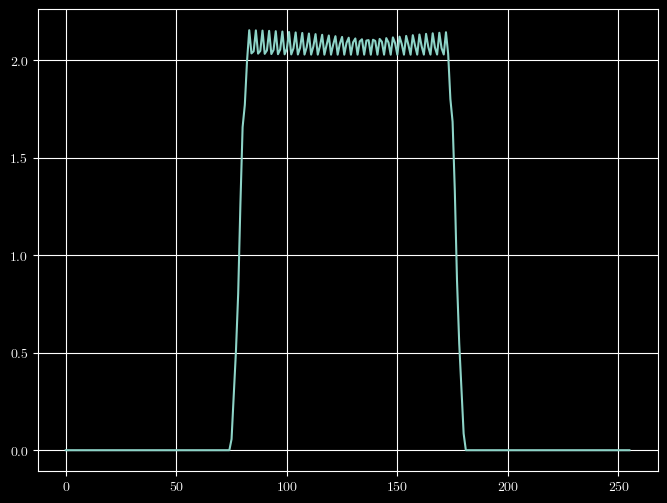

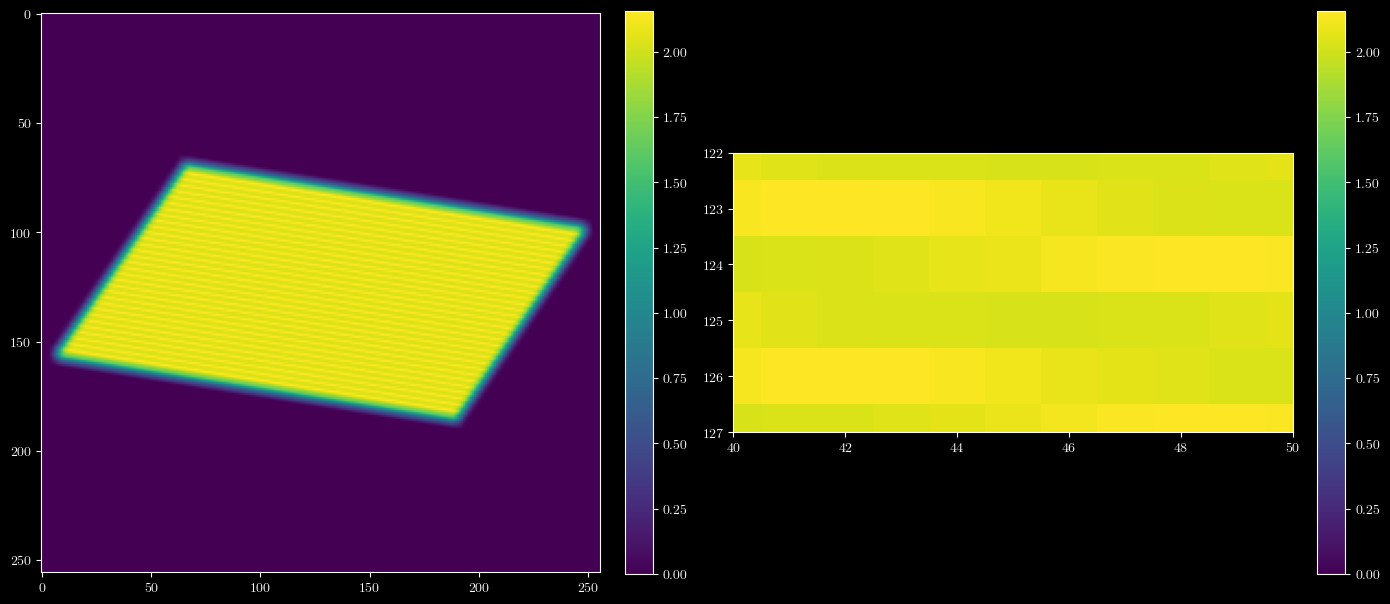

In [16]:
plt.style.use("dark_background")

plt.figure(figsize=(8,6))
plt.plot(strain_mosa[:, 128, ntheta // 2, nphi // 2, nchi // 2])
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
im = ax[0].imshow(strain_mosa[:, :, ntheta // 2, nphi // 2, nchi // 2], cmap="viridis")
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

im = ax[1].imshow(strain_mosa[:, :, ntheta // 2, nphi // 2, nchi // 2], cmap="viridis")
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

ax[1].set_xlim([40, 50])
ax[1].set_ylim([127, 122])

plt.tight_layout()
plt.show()


